# Introduction to the project




In this notebook, we'll go through the code a neural network to predict what is contained within the image (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck). We will go through the following in this notebook:

- Exploring and Processing the Data
- Building and Training our Convolutional Neural Network
- Testing out with our own images

PS : Note that the results you get might differ slightly from the blogpost as there is a degree of randomness in the way we split our dataset as well as the initialization of our neural network.

# Exploring and Processing the Data

We will first have to download our dataset, CIFAR-10. The details of the dataset are as follows:
- Images to be recognized: Tiny images of 32 * 32 pixels
- Labels: 10 possible labels (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck)
- Dataset size: 60000 images, split into 50000 for training and 10000 for testing

In [1]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
print('x_train shape:', x_train.shape)

x_train shape: (50000, 32, 32, 3)


In [ ]:
print('y_train shape:', y_train.shape)

y_train shape: (50000, 1)


We will now take a look at an individual image. If we print out the first image of our training dataset (x_train[0]):

In [ ]:
print(x_train[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


In order to see the image as an image rather than a series of pixel value numbers, we will use a function from matplotlib:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

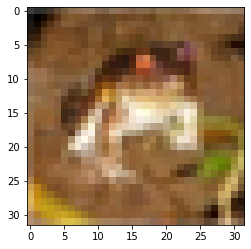

In [ ]:
img = plt.imshow(x_train[0])

In [ ]:
print('The label is:', y_train[0])

The label is: [6]


Let's explore one more image, the second image (with index 1 instead of 0) in our training dataset:

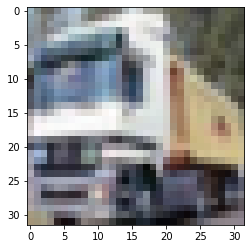

In [ ]:
img = plt.imshow(x_train[1])

In [ ]:
print('The label is:', y_train[1])

The label is: [9]


What we really want is the probability of each of the 10 different classes. For that, we need 10 output neurons in our neural network. Since we have 10 output neurons, our labels must match this as well. To do this, we convert the label into a set of 10 numbers where each number represents if the image belongs to that class or not. So if an image belongs to the first class, the first number of this set will be a 1 and all other numbers in this set will be a 0. To convert our labels to our one-hot encoding, we use a function in Keras:

In [ ]:
import keras
y_train_one_hot = keras.utils.to_categorical(y_train, 10)
y_test_one_hot = keras.utils.to_categorical(y_test, 10)

In [ ]:
print('The one hot label is:', y_train_one_hot[1])

The one hot label is: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


A common step we do is to let the values to be between 0 and 1, which will aid in the training of our neural network. Since our pixel values already take the values between 0 and 255, we simply need to divide by 255.

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
x_train[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

# Building and Training our Convolutional Neural Network

We need to define the architecture (template) first before fitting the best numbers into this architecture by learning from the data. In summary, the architecture we will build in this post is this:

- Conv Layer (Filter size 3x3, Depth 32)
- Conv Layer (Filter size 3x3, Depth 32)
- Max Pool Layer (Filter size 2x2)
- Dropout Layer (Prob of dropout 0.25)
- Conv Layer (Filter size 3x3, Depth 64)
- Conv Layer (Filter size 3x3, Depth 64)
- Max Pool Layer (Filter size 2x2)
- Dropout Layer (Prob of dropout 0.25)
- FC Layer (512 neurons)
- Dropout Layer (Prob of dropout 0.5)
- FC Layer, Softmax (10 neurons)


We will be using Keras to build our architecture. Let's import the code from Keras that we will need to use:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

We then call an empty Sequential model and 'add' to this model layer by layer:

In [ ]:
model = Sequential()

The first layer is a conv layer with filter size 3x3, stride size 1 (in both dimensions), and depth 32. The padding is the 'same' and the activation is 'relu' (these two settings will apply to all layers in our CNN). We add this layer to our empty sequential model using the function model.add().

The first number 32 refers to the depth. The next pair of numbers (3,3) refer to the filter width and size. Then, we specify activation which is 'relu' and padding which is 'same'. Notice that we did not specify stride. This is because stride=1 is a default setting, and unless we want to change this setting, we need not specify it.

If you recall, we also need to specify an input size for our first layer; subsequent layers does not have this specification since they can infer the input size from the output size of the previous layer.

All that being said, our first layer in code looks like this:

In [ ]:
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32,32,3)))

Our second layer looks like this in code (we don't need to specify the input size):

In [ ]:
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

The next layer is a max pooling layer with pool size 2 x 2 and stride 2 (in both dimensions). The default for a max pooling layer stride is the pool size, so we don't have to specify the stride:

In [ ]:
model.add(MaxPooling2D(pool_size=(2, 2)))

Lastly, we add a dropout layer with probability 0.25 of dropout so as to prevent overfitting:

In [ ]:
model.add(Dropout(0.25))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


And there we have it, our first four layers in code. The next four layers look really similar (except the depth of the conv layer is 64 instead of 32):

In [ ]:
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

Lastly, we have to code in our fully connected layer. However, at this point, our neurons are spatially arranged in a cube-like format rather than in just one row. To make this cube-like format of neurons into one row, we have to first flatten it. We do so by adding a Flatten layer:

In [ ]:
model.add(Flatten())

Now, we have a dense (FC) layer of 512 neurons with relu activation:

In [ ]:
model.add(Dense(512, activation='relu'))

We add another dropout of probability 0.5:

In [ ]:
model.add(Dropout(0.5))

And lastly, we have a dense (FC) layer with 10 neurons and softmax activation:

In [ ]:
model.add(Dense(10, activation='softmax'))

And we're done with specifying our architecture! To see a summary of the full architecture, we run the code:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)         

We now fill in the best numbers after we've specified our architecture. We'll compile the model with our settings below.

The loss function we use is called categorical cross entropy, which is applicable for a classification problem of many classes. 

The optimizer we use here is Adam which is simply a type of stochastic gradient descent (with a few modifications) so that it trains better. 

Lastly, we want to track the accuracy of our model.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

And now, it's time to run our training.

We train our model with batch size 32 and 20 epochs. We use the setting validation_split=0.2 instead of validation_data. With this shortcut, we did not need to split our dataset into a train and validation set at the start! Instead, we simply specify how much of our dataset will be used as a validation set. In this case, 20% of our dataset is used as a validation set. This will take a while on a CPU, so you might want to start training and get some coffee before coming back.

In [ ]:
hist = model.fit(x_train, y_train_one_hot, 
           batch_size=32, epochs=20, 
           validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40000 samples, validate on 10000 samples
Epoch 1/20





40000/40000 [==============================] - 301s 8ms/step - loss: 1.5777 - acc: 0.4233 - val_loss: 1.2018 - val_acc: 0.5643
Epoch 2/20
40000/40000 [==============================] - 300s 8ms/step - loss: 1.1442 - acc: 0.5923 - val_loss: 0.9830 - val_acc: 0.6534
Epoch 3/20
40000/40000 [==============================] - 300s 7ms/step - loss: 0.9871 - acc: 0.6504 - val_loss: 0.9007 - val_acc: 0.6812
Epoch 4/20
40000/40000 [==============================] - 299s 7ms/step - loss: 0.8898 - acc: 0.6829 - val_loss: 0.7946 - val_acc: 0.7179
Epoch 5/20
40000/40000 [==============================] - 297s 7ms/step - loss: 0.8228 - acc: 0.7100 - val_loss: 0.7626 - val_acc: 0.7369
Epoch 6/20
40000/40000 [==============================] - 298s 7ms/step - loss: 0.7657 - acc: 0.7319 - val_loss: 0.7251 - val_acc: 0.7484
Epoch 7/20
40000/400

KeyboardInterrupt: ignored

After you've done training, we can visualize the model training and validation loss as well as training / validation accuracy over the number of epochs using the below code:

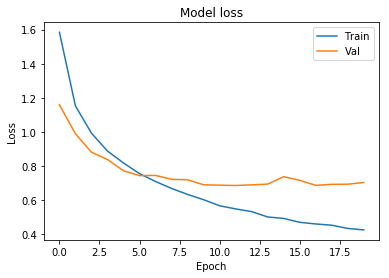

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

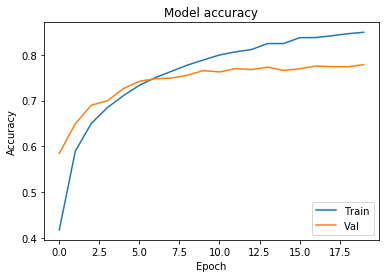

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
%cd intuitive-deep-learning/Part\ 2\:\ Image\ Recognition\ CIFAR-10

/content/intuitive-deep-learning/Part 2: Image Recognition CIFAR-10


In [ ]:
model.load_weights("my_cifar10_model.h5")

Once we are done with tweaking our hyperparameters, we can run it on our test dataset below:

In [ ]:
model.evaluate(x_test, y_test_one_hot)[1]

10000/10000 [==============================] - 16s 2ms/step


0.7709

At this point, you might want to save your trained model (since you've spent so long waiting for it to train). The model will be saved in a file format called HDF5 (with the extension .h5). We save our model with this line of code:

In [ ]:
model.save('my_cifar10_model.h5')

# Testing out with your own images

Now that we have a model, let's try it on our own images. To do so, place your image in the same directory as your notebook. For the purposes of this post, I'm going to use an image of a cat (which you can download here(link)). Now, we read in our JPEG file as an array of pixel values:

In [ ]:
my_image = plt.imread("cat.jpg")

The first thing we have to do is to resize the image of our cat so that we can fit it into our model (input size of 32 * 32 * 3).

In [ ]:
from skimage.transform import resize
my_image_resized = resize(my_image, (32,32,3))

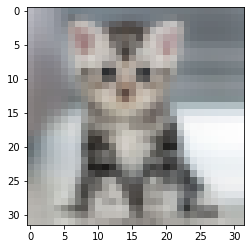

In [ ]:
img = plt.imshow(my_image_resized)

And now, we see what our trained model will output when given an image of our cat, using this code:

In [ ]:
import numpy as np
probabilities = model.predict(np.array( [my_image_resized,] ))

In [ ]:
probabilities

array([[0.00909029, 0.00100832, 0.00513347, 0.7171852 , 0.05192704,
        0.06266063, 0.02170254, 0.10667082, 0.01079966, 0.01382202]],
      dtype=float32)

In [ ]:
number_to_class = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
index = np.argsort(probabilities[0,:])
print("Most likely class:", number_to_class[index[9]], "-- Probability:", probabilities[0,index[9]])
print("Second most likely class:", number_to_class[index[8]], "-- Probability:", probabilities[0,index[8]])
print("Third most likely class:", number_to_class[index[7]], "-- Probability:", probabilities[0,index[7]])
print("Fourth most likely class:", number_to_class[index[6]], "-- Probability:", probabilities[0,index[6]])
print("Fifth most likely class:", number_to_class[index[5]], "-- Probability:", probabilities[0,index[5]])

Most likely class: cat -- Probability: 0.7171852
Second most likely class: horse -- Probability: 0.10667082
Third most likely class: dog -- Probability: 0.062660635
Fourth most likely class: deer -- Probability: 0.051927038
Fifth most likely class: frog -- Probability: 0.021702545


As you can see, the model has accurately predicted that this is indeed an image of a cat. Now, this isn't the best model we have and accuracy has been quite low, so don't expect too much out of it